In [3]:
import numpy as np
class RNN:
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.cache = None
    def forward(self, x, h_prev):
        wx, wh, b = self.params
        t = np.dot(wh, h_prev) + np.dot(wx, x) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        
        return h_next
    def backward(self, dh_next):
        wx, wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, wh.T)
        dwx = np.dot(x.T, dt)
        dx = np.dot(dt, wx.T)
        
        self.grads[0][...] = dwx
        self.grads[1][...] = dwh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [ ]:
class TimeRNN:
    def __init__(self, wx, wh, b, stateful=False):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
    def set_state(self, h):
        self.h = h
    def reset_state(self):
        self.h = None
    def forward(self, xs):
        wx, wh, b = self.params
        N, T, D = xs.shape
        D, H = wx.shape
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs
    def backward(self, dhs):
        wx, wh, b = self.params
        N, T, H = dhs.shape
        D, H = wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

In [15]:
from common.time_layers import *
import numpy as np

class SimpleRnnlm:  # RNN Language Model
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        embed_w = (np.random.randn(vocab_size, wordvec_size) / 100).astype('f')
        rnn_wx = (np.random.randn(wordvec_size, hidden_size) / np.sqrt(wordvec_size)).astype('f')
        rnn_wh = (np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)).astype('f')
        rnn_b = np.zeros(hidden_size).astype('f')
        affine_w = (np.random.randn(hidden_size, vocab_size) / np.sqrt(hidden_size)).astype('f')
        affine_b = np.zeros(vocab_size).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_w),
            TimeRNN(rnn_wx, rnn_wh, rnn_b, stateful=True),
            TimeAffine(affine_w, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)

In [17]:
xs.shape, ts.shape

((999,), (999,))

In [18]:
max_iters = data_size // (time_size*batch_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = data_size // batch_size
offsets = [i * jump for i in range(batch_size)]

In [19]:
offsets

[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

| EPOCH 1 | PPL 363.69
| EPOCH 2 | PPL 242.75
| EPOCH 3 | PPL 220.24
| EPOCH 4 | PPL 214.16
| EPOCH 5 | PPL 204.67
| EPOCH 6 | PPL 202.00
| EPOCH 7 | PPL 198.39
| EPOCH 8 | PPL 197.02
| EPOCH 9 | PPL 191.80
| EPOCH 10 | PPL 192.27
| EPOCH 11 | PPL 188.24
| EPOCH 12 | PPL 191.91
| EPOCH 13 | PPL 190.98
| EPOCH 14 | PPL 190.91
| EPOCH 15 | PPL 189.51
| EPOCH 16 | PPL 185.86
| EPOCH 17 | PPL 184.12
| EPOCH 18 | PPL 181.44
| EPOCH 19 | PPL 181.72
| EPOCH 20 | PPL 181.83
| EPOCH 21 | PPL 181.84
| EPOCH 22 | PPL 179.77
| EPOCH 23 | PPL 174.55
| EPOCH 24 | PPL 175.03
| EPOCH 25 | PPL 174.76
| EPOCH 26 | PPL 175.59
| EPOCH 27 | PPL 168.70
| EPOCH 28 | PPL 169.57
| EPOCH 29 | PPL 167.59
| EPOCH 30 | PPL 161.77
| EPOCH 31 | PPL 161.71
| EPOCH 32 | PPL 157.92
| EPOCH 33 | PPL 158.46
| EPOCH 34 | PPL 152.28
| EPOCH 35 | PPL 150.04
| EPOCH 36 | PPL 147.83
| EPOCH 37 | PPL 140.28
| EPOCH 38 | PPL 138.54
| EPOCH 39 | PPL 132.27
| EPOCH 40 | PPL 126.60
| EPOCH 41 | PPL 130.06
| EPOCH 42 | PPL 121.38
|

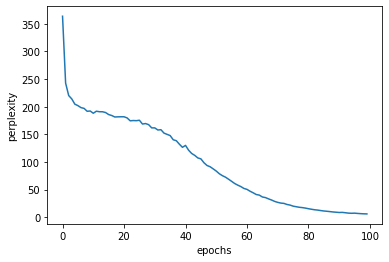

In [20]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset+time_idx)%data_size]
                batch_t[i, t] = ts[(offset+time_idx)%data_size]
            time_idx += 1
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print('| EPOCH %d | PPL %.2f' % (epoch+1, ppl))
    ppl_list += [float(ppl)]
    total_loss, loss_count = 0, 0

x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()